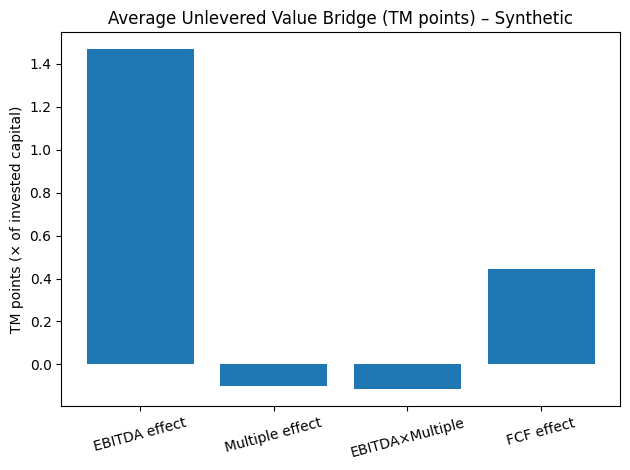

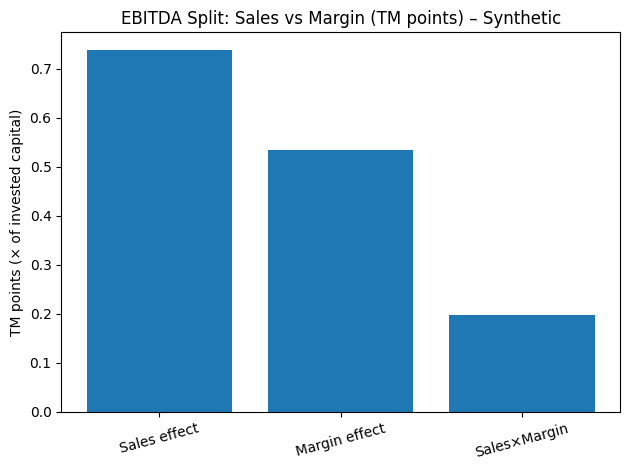

In [5]:
# Value Creation Decomposition Toolkit (aligned to Achleitner et al. 2010; Achleitner, Braun & Puche 2015; Söffge & Braun 2017)
#
# Core analytics to compute levered TM, unlevered TM, leverage effect, and the unlevered value bridge:
#    - EBITDA effect (split into Sales effect, Margin effect, and Sales×Margin combo)
#    - Multiple expansion effect
#    - EBITDA×Multiple combination effect
#    - Free Cash Flow (FCF) effect
# It also includes an example with synthetic data and sample visualizations.
#
# IMPORTANT (methodology parity):
# - Times-Money (TM_levered) is computed at equity level including interim dividends and equity injections.
# - Unlevering formula (per Achleitner family of papers):
#     TMu = (TMl + ((1 + r_d)**T - 1) * (D/E_avg)) / (1 + D/E_avg)
#   where r_d is annual cost of debt and T is holding period in years; D/E_avg is average debt-to-equity over holding.
# - Multiple effect uses ENTRY EBITDA times Δmultiple.
# - EBITDA effect uses ENTRY multiple times ΔEBITDA.
# - Combination effects included to ensure additivity.
# - FCF effect = (Debt_entry - Debt_exit) + Dividends_paid - Equity_injected (absolute, then scaled to TM points).

from dataclasses import dataclass, asdict
from typing import Optional, List, Dict, Any, Tuple
import pandas as pd
import numpy as np
import math
# import caas_jupyter_tools as cj
import matplotlib.pyplot as plt

# -----------------------------
# 0) SCHEMA & VALIDATION
# -----------------------------

REQUIRED_COLUMNS = [
    # Identifiers / segmentation
    "deal_id",                 # unique id
    "region",                  # e.g., 'Europe', 'North America', 'DACH', etc.
    "industry",                # e.g., 'Industrials', 'Tech', etc.
    "deal_type",               # e.g., 'P2P', 'P2P-private', 'Secondary', etc. (free text)
    # Dates & holding period
    "entry_date",              # datetime-like
    "exit_date",               # datetime-like
    "holding_years",           # float; if absent we compute from dates (year fraction)
    # Entry/Exit core metrics (enterprise level, unless specified as equity)
    "ev_entry",                # Enterprise Value at entry (100% basis)
    "ev_exit",                 # Enterprise Value at exit (100% basis)
    "debt_entry",              # Net debt at entry (debt - cash), signed as positive if net debt
    "debt_exit",               # Net debt at exit
    "equity_entry",            # Equity value at entry (100% basis)
    "equity_exit",             # Equity value at exit (100% basis)
    # Operating metrics
    "sales_entry",
    "sales_exit",
    "ebitda_entry",
    "ebitda_exit",
    # Valuation multiples
    "ev_ebitda_entry",         # EV/EBITDA at entry
    "ev_ebitda_exit",          # EV/EBITDA at exit
    # Interim cash flows (equity perspective)
    "dividends_paid",          # total dividends to equity during holding (positive if paid out to equity)
    "equity_injected",         # additional equity injected during holding (positive if injected)
    # Leverage unlevering parameters
    "avg_de_ratio",            # average Debt/Equity over holding period (dimensionless)
    "cost_of_debt_annual"      # annual cost of debt r_d (as decimal, e.g., 0.09 for 9%)
]

def coerce_and_validate(df: pd.DataFrame) -> pd.DataFrame:
    """Coerce types, compute holding_years if missing, and validate required fields."""
    missing = [c for c in REQUIRED_COLUMNS if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")
    # Coerce dates
    df = df.copy()
    df["entry_date"] = pd.to_datetime(df["entry_date"])
    df["exit_date"] = pd.to_datetime(df["exit_date"])
    if df["holding_years"].isna().any():
        # Compute year fraction (365.25 day year)
        df["holding_years"] = (df["exit_date"] - df["entry_date"]).dt.days / 365.25
    # Basic sanity checks
    if (df["ebitda_entry"] <= 0).any() or (df["ev_ebitda_entry"] <= 0).any():
        # Methodology requires positive entry EBITDA and multiple to avoid undefined pieces
        pass  # Do not raise; flag instead
    return df

# -----------------------------
# 1) CORE COMPUTATION PER DEAL
# -----------------------------

def compute_value_bridge_row(row: pd.Series) -> Dict[str, Any]:
    """Compute levered/unlevered TM and the unlevered value bridge components for a deal (row-level)."""
    # Inputs
    equity_entry = row["equity_entry"]
    equity_exit = row["equity_exit"]
    dividends_paid = row["dividends_paid"]
    equity_injected = row["equity_injected"]
    invested_capital = equity_entry + equity_injected

    # Guard against zero invested capital
    if invested_capital == 0 or np.isnan(invested_capital):
        return {"error": "Zero or NaN invested_capital; cannot compute TM."}

    # Levered TM (equity perspective)
    net_capital_gain = (equity_exit - equity_entry) + dividends_paid - equity_injected
    tm_levered = net_capital_gain / invested_capital

    # Unlevering (Achleitner-style)
    r_d = row["cost_of_debt_annual"]
    T = row["holding_years"]
    de_avg = row["avg_de_ratio"]
    total_cost_of_debt = (1 + r_d) ** T - 1  # cumulative cost over holding
    tm_unlevered = (tm_levered + total_cost_of_debt * de_avg) / (1 + de_avg)
    leverage_effect_tm = tm_levered - tm_unlevered

    # Components (absolute currency terms)
    m_entry = row["ev_ebitda_entry"]
    m_exit = row["ev_ebitda_exit"]
    ebitda_entry = row["ebitda_entry"]
    ebitda_exit  = row["ebitda_exit"]
    sales_entry  = row["sales_entry"]
    sales_exit   = row["sales_exit"]
    debt_entry   = row["debt_entry"]
    debt_exit    = row["debt_exit"]

    # Basic derived
    delta_m = m_exit - m_entry
    delta_ebitda = ebitda_exit - ebitda_entry
    delta_sales = sales_exit - sales_entry
    # EBITDA margins
    margin_entry = (ebitda_entry / sales_entry) if sales_entry not in [0, np.nan] else np.nan
    margin_exit  = (ebitda_exit  / sales_exit)  if sales_exit  not in [0, np.nan] else np.nan
    delta_margin = (margin_exit - margin_entry) if (not np.isnan(margin_entry) and not np.isnan(margin_exit)) else np.nan

    # Effects (absolute currency, consistent with Achleitner 2015 example)
    multiple_effect_abs = delta_m * ebitda_entry
    ebitda_effect_abs   = delta_ebitda * m_entry
    combo_ebitda_mult_abs = delta_ebitda * delta_m

    # FCF effect (equity perspective; deleveraging + interim payouts - injections)
    fcf_effect_abs = (debt_entry - debt_exit) + dividends_paid - equity_injected

    # Sales/Margin split of EBITDA effect
    if not np.isnan(margin_entry):
        sales_effect_abs = delta_sales * margin_entry * m_entry
    else:
        sales_effect_abs = np.nan
    if not np.isnan(delta_margin):
        margin_effect_abs = delta_margin * sales_entry * m_entry
    else:
        margin_effect_abs = np.nan
    if not np.isnan(delta_margin) and not np.isnan(delta_sales):
        combo_sales_margin_abs = delta_sales * delta_margin * m_entry
    else:
        combo_sales_margin_abs = np.nan

    # Sanity checks: expected sums (unlevered absolute should reconcile)
    # Sum of unlevered components (absolute): EBITDA effect + Multiple effect + EBITDA×Multiple combo + FCF effect
    unlev_components_abs = (
        ebitda_effect_abs
        + multiple_effect_abs
        + combo_ebitda_mult_abs
        + fcf_effect_abs
    )
    # Convert absolute components to TM points by dividing by invested capital
    def to_tm(x):
        return x / invested_capital if not np.isnan(x) else np.nan

    results = {
        # IDs / segmentation
        "deal_id": row["deal_id"],
        "region": row["region"],
        "industry": row["industry"],
        "deal_type": row["deal_type"],
        "entry_date": row["entry_date"],
        "exit_date": row["exit_date"],
        "holding_years": T,

        # Scaling base
        "invested_capital": invested_capital,

        # Levered vs Unlevered
        "tm_levered": tm_levered,
        "tm_unlevered": tm_unlevered,
        "leverage_effect_tm": leverage_effect_tm,

        # Absolute effects
        "multiple_effect_abs": multiple_effect_abs,
        "ebitda_effect_abs": ebitda_effect_abs,
        "combo_ebitda_mult_abs": combo_ebitda_mult_abs,
        "fcf_effect_abs": fcf_effect_abs,
        "sales_effect_abs": sales_effect_abs,
        "margin_effect_abs": margin_effect_abs,
        "combo_sales_margin_abs": combo_sales_margin_abs,
        "unlev_components_abs_total": unlev_components_abs,

        # TM (points) for effects (scaled by invested capital)
        "multiple_effect_tm": to_tm(multiple_effect_abs),
        "ebitda_effect_tm": to_tm(ebitda_effect_abs),
        "combo_ebitda_mult_tm": to_tm(combo_ebitda_mult_abs),
        "fcf_effect_tm": to_tm(fcf_effect_abs),
        "sales_effect_tm": to_tm(sales_effect_abs),
        "margin_effect_tm": to_tm(margin_effect_abs),
        "combo_sales_margin_tm": to_tm(combo_sales_margin_abs),
        "unlev_components_tm_total": to_tm(unlev_components_abs),

        # Reconciliation flags
        "recon_tm_ok": np.isfinite(tm_unlevered) and np.isfinite(leverage_effect_tm) and abs((tm_unlevered + leverage_effect_tm) - tm_levered) < 1e-6,
        "recon_unlev_abs_vs_tm": abs(unlev_components_abs - tm_unlevered * invested_capital) < 1e-6
    }
    return results

def compute_value_bridge(df: pd.DataFrame) -> pd.DataFrame:
    """Apply value bridge computation to all rows."""
    dfc = coerce_and_validate(df)
    out_records: List[Dict[str, Any]] = []
    for _, row in dfc.iterrows():
        out_records.append(compute_value_bridge_row(row))
    res = pd.DataFrame(out_records)
    return res

# -----------------------------
# 2) SEGMENTATION / GROUPING
# -----------------------------

def summarize_by(df_bridge: pd.DataFrame, by: Optional[List[str]] = None) -> pd.DataFrame:
    """Aggregate TM contributions (mean across deals) by segment."""
    metrics = [
        "tm_levered", "tm_unlevered", "leverage_effect_tm",
        "multiple_effect_tm", "ebitda_effect_tm", "combo_ebitda_mult_tm", "fcf_effect_tm",
        "sales_effect_tm", "margin_effect_tm", "combo_sales_margin_tm",
        "unlev_components_tm_total"
    ]

    if by is None or len(by) == 0:
        grp = df_bridge[metrics].mean().to_frame().T
        grp["n_deals"] = len(df_bridge)
        return grp
    else:
        grp = df_bridge.groupby(by)[metrics].mean().reset_index()
        counts = df_bridge.groupby(by).size().reset_index(name="n_deals")
        return grp.merge(counts, on=by, how="left")

# -----------------------------
# 3) VISUALIZATIONS
# -----------------------------

def plot_average_bridge(avg_row: pd.Series, title: str = "Average Unlevered Value Bridge (TM points)") -> None:
    """Plot a simple bar chart of average unlevered value bridge components (TM points)."""
    # One plot, no specific colors
    components = [
        ("EBITDA effect", "ebitda_effect_tm"),
        ("Multiple effect", "multiple_effect_tm"),
        ("EBITDA×Multiple", "combo_ebitda_mult_tm"),
        ("FCF effect", "fcf_effect_tm"),
    ]
    values = [avg_row[c2] for _, c2 in components]
    labels = [c1 for c1, _ in components]

    plt.figure()
    plt.bar(labels, values)
    plt.ylabel("TM points (× of invested capital)")
    plt.title(title)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

def plot_average_sales_margin_split(avg_row: pd.Series, title: str = "EBITDA Split: Sales vs Margin (TM points)") -> None:
    """Plot sales vs margin split of EBITDA effect (including combination)."""
    components = [
        ("Sales effect", "sales_effect_tm"),
        ("Margin effect", "margin_effect_tm"),
        ("Sales×Margin", "combo_sales_margin_tm"),
    ]
    values = [avg_row[c2] for _, c2 in components]
    labels = [c1 for c1, _ in components]

    plt.figure()
    plt.bar(labels, values)
    plt.ylabel("TM points (× of invested capital)")
    plt.title(title)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

# -----------------------------
# 4) EXAMPLE WITH SYNTHETIC DATA (you can replace with your real dataset)
# -----------------------------

example_df = pd.DataFrame([
    {
        "deal_id": "D1",
        "region": "Europe",
        "industry": "Industrials",
        "deal_type": "Private-to-Private",
        "entry_date": "2010-01-01",
        "exit_date":  "2014-01-01",
        "holding_years": np.nan,  # will be computed
        "ev_entry": 100.0,
        "ev_exit": 165.0,
        "debt_entry": 50.0,
        "debt_exit": 30.0,
        "equity_entry": 50.0,
        "equity_exit": 135.0,
        "sales_entry": 100.0,
        "sales_exit": 120.0,
        "ebitda_entry": 10.0,
        "ebitda_exit": 15.0,
        "ev_ebitda_entry": 10.0,
        "ev_ebitda_exit": 11.0,
        "dividends_paid": 20.0,
        "equity_injected": 15.0,   # NOTE: positive if injected during holding
        "avg_de_ratio": ( (50/50) + (30/135) ) / 2.0,  # matches the 2015 example (≈0.61)
        "cost_of_debt_annual": 0.09
    },
    # Add a second synthetic deal to demonstrate averaging
    {
        "deal_id": "D2",
        "region": "Europe",
        "industry": "Tech",
        "deal_type": "Secondary",
        "entry_date": "2011-06-30",
        "exit_date":  "2016-06-30",
        "holding_years": np.nan,
        "ev_entry": 200.0,
        "ev_exit": 320.0,
        "debt_entry": 120.0,
        "debt_exit": 90.0,
        "equity_entry": 80.0,
        "equity_exit": 230.0,
        "sales_entry": 150.0,
        "sales_exit": 220.0,
        "ebitda_entry": 15.0,
        "ebitda_exit": 28.0,
        "ev_ebitda_entry": 13.33,
        "ev_ebitda_exit": 11.43,
        "dividends_paid": 10.0,
        "equity_injected": 0.0,
        "avg_de_ratio": ( (120/80) + (90/230) ) / 2.0,
        "cost_of_debt_annual": 0.08
    }
])

bridge = compute_value_bridge(example_df)

# Summaries
avg_all = summarize_by(bridge, by=None).iloc[0]
avg_by_industry = summarize_by(bridge, by=["industry"])

# Display results
# cj.display_dataframe_to_user("Per-deal value bridge (synthetic demo)", bridge.round(4))
# cj.display_dataframe_to_user("Average TM contributions (overall and by industry)", pd.concat([avg_all.to_frame().T, avg_by_industry], ignore_index=True).round(4))

# Plots
plot_average_bridge(avg_all, title="Average Unlevered Value Bridge (TM points) – Synthetic")
plot_average_sales_margin_split(avg_all, title="EBITDA Split: Sales vs Margin (TM points) – Synthetic")
